**ANALYSIS OF TARIFFS AND TERMINALS OF THE CHARGEX**


Chargex is a gadget charging service with a network throughout the Russian Federation and abroad, offering users to rent a power bank. 

**Data:**
- csv file with information about Power Banks rents

- csv file with information about transactions

- csv file with information about terminals (stations)

**Target:**
- determine the tariff parameter that can be offered to users in order to increase the frequency of using the service and income.
- determine the payback of the station and the factors affecting the income

**Analysis steps**

1. Primary data preprocessing
2. Analysis of tariffs.
3. Analysis of tariffs.
4. Analysis of terminals.
5. General conclusions and recommendations

**Study conducted for:**
- Russian tariffs (except Waiter and Demo) and terminals
- completed rents only
- price af the rent lower than 3000 rub
- period from 2020-06-01 to 2022-10-31
- terminals with status CONNECTED

**Conclusions and recommendations**
1. An increase in the frequency of returning users does not always guarantee an increase in company revenues due to product features, namely, the availability of free periods of using services for some tariff groups 
2. Users are better off returning to free time and daily billing plans. At the same time, the best tariff for returning users is the tariff with free 24 hours at the beginning, and then daily payment, which is not surprising - this tariff has the largest amount of free time. 
3. The number of paid rentals per user for the freetime_day tariff has decreased by 3 times compared to the same indicator for all rentals. 
4. Despite the low average rental cost for the freeday_day100rub tariff, the huge frequency of user returns provides the highest revenue per user for this tariff. 
5. There is a user group of about 6% who use only free periods
6. Only 28% of stations pay off.
7. The real payback period of investments is more than 1 year
8. To analyze the influence of the type of establishment on revenue, it is necessary to control the movement of stations with the collection of information about the start and end dates of the station in a particular establishment.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import seaborn as sns
sns.set(context='notebook', style='whitegrid', 
        palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc={'figure.figsize':(15,7)})
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison 
import matplotlib.pyplot as plt
import ast
import warnings
import os
from dotenv import load_dotenv
import requests
import json
warnings.simplefilter(action='ignore')
from ast import literal_eval

# Primary data preprocessing

## Rents

### Column names, duplicates, gaps

In [2]:
rents = pd.read_csv('rents.csv', low_memory=False)

In [3]:
rents.columns = [x.replace('_', '').replace('.', '_').lower() for x in rents.columns]
rents.columns

Index(['id', 'completionstation', 'creditcardid',
       'currenttariff_namegrouptariffs', 'currenttariff_period',
       'currenttariff_price', 'currenttariff_tariffname',
       'currenttariff_timeforwork', 'currenttariff_typetime',
       'currenttariff_workingtimeinterval', 'debt', 'finisheddate',
       'grouptariffs_id', 'grouptariffs_groupname', 'grouptariffs_location',
       'grouptariffs_periodcount', 'grouptariffs_tariffs',
       'notificationstatus', 'powerbankid', 'price', 'rentstatus', 'startdate',
       'startstation', 'stationid', 'stationnumber',
       'tarifftext_locationfortariff', 'tarifftext_tarifftext', 'totalamount',
       'transaction', 'updateddate', 'user_id', 'user_blocking',
       'user_createddate', 'user_roles', 'user_telegramchatid',
       'user_telegramloginstate', 'user_webuser'],
      dtype='object')

In [4]:
rents.duplicated().sum()

0

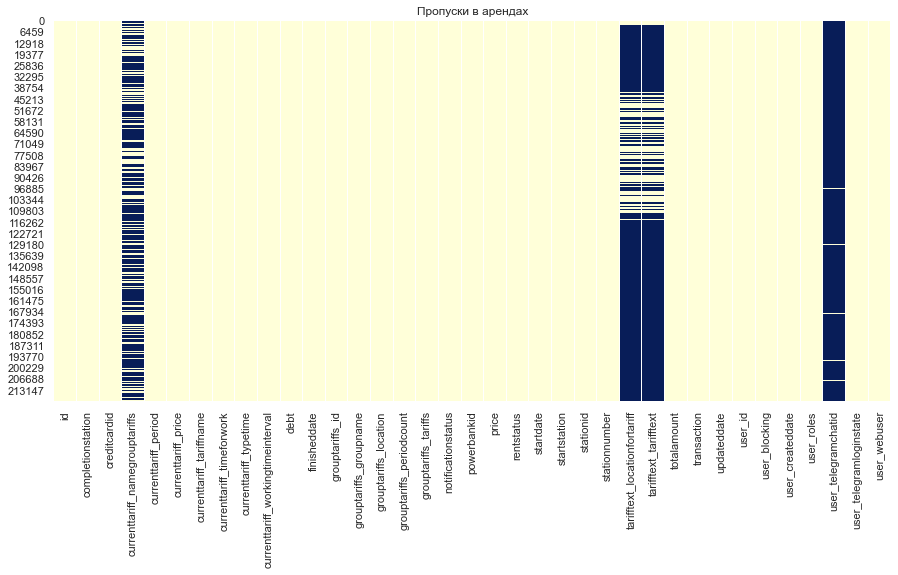

In [5]:
sns.heatmap(rents.isnull(), cbar=False, cmap="YlGnBu")
plt.title('Пропуски в арендах');

**Conclusion**
- there are no duplicates, the names of the columns are given in a normal form
- most of the gaps in the user_telegram_chatid column indicate that the vast majority of clients (98%) did not use telegrams to receive the service - this feature is not informative
- columns tarifftext_locationfortariff, tarifftext_tarifftext also contain about 78% of gaps - we are not interested in them, so we will not fill them in
- currenttariff_namegrouptariffs with gaps will be used in the future along with such features as currenttariff_tariffname and grouptariffs_periodcount to define tariff groups based on their characteristics

### Selection of features for further analysis

In [6]:
rents =rents.drop(columns = ['creditcardid',
                            # 'class', 'user_phonenumber',
                            'grouptariffs_id', 'grouptariffs_tariffs',
                            'notificationstatus', 'powerbankid', 
                            'user_blocking',
                            'user_roles', 'user_telegramchatid',
                            'tarifftext_tarifftext'])

Leave only russian rents with status FINISHED 

In [7]:
rents = rents.query('grouptariffs_location == "RU" and rentstatus == "FINISHED"')

**Conclusion**
We will conduct research only for Russian tariffs and ended rents

### Analysis of quantitative values to determine their correctness

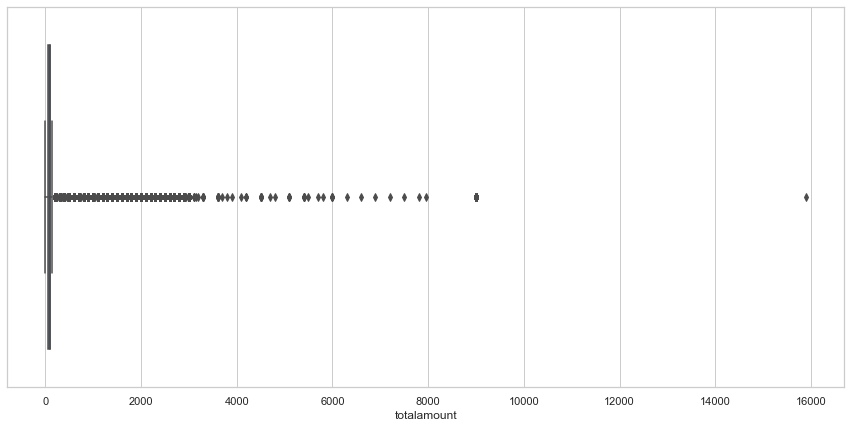

In [8]:
sns.boxplot(rents.totalamount);

Abnormally large values in the amount of rent are most likely associated with the loss or non-return of the power bank
in accordance with the information from the client's website "The user's card will be debited for rent every day until he returns the battery to the terminal. After 30 days of rent, the power bank is considered redeemed" https://topfranchise.ru/products/franchiza-chargex-servis -udobnoy-zaryadki-gadzhetov/
Let's leave 99% of the data - there we will be sure that the rental amount really reflects the cost of rent in accordance with the rental time, and not with the non-return of the power bank for a long time

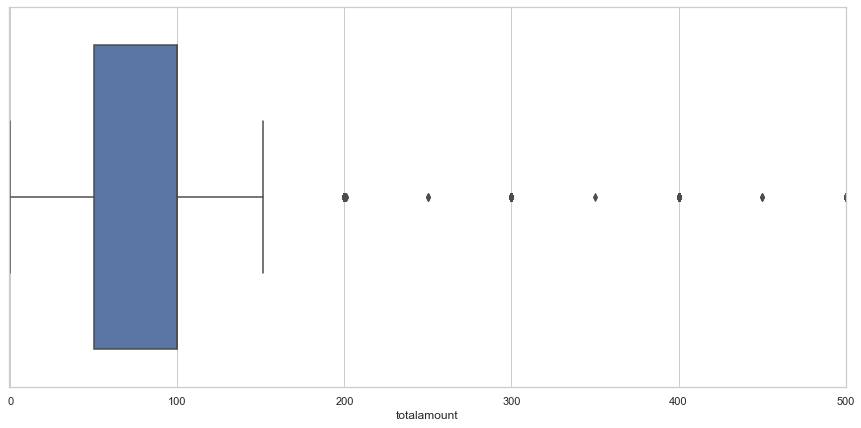

In [9]:
quantile99_total_amount = rents['totalamount'].quantile(0.99)
rents = rents.query('totalamount <= @quantile99_total_amount')
sns.boxplot(rents.totalamount)
plt.xlim(-1,500);

**Conclusion**
We deleted 1% of data with abnormally high rental values (most likely due to the loss of power bank). Most rentals do not exceed 150 rubles

### Tariff grouping

Define tariff groups - write down each tariff in the format - availability of a free period / price per hour / price per day
Data obtained by comparing information from several columns - currenttariff_namegrouptariffs, currenttariff_tariffname, currenttariff_period

In [10]:
rents = rents.rename(columns = {'currenttariff_namegrouptariffs':'cur_tariff_group'})

In [11]:
rents.loc[rents['cur_tariff_group'].isna(), 'cur_tariff_group'] = rents.loc[rents['cur_tariff_group'].isna(), 'currenttariff_tariffname']
rents['cur_tariff_group'].unique()

array(['Промо', 'Час 50 рублей', 'Рублевые Россия',
       'Рублёвый. Час и сутки с бес. - 30 минут бесплатно',
       'Рублёвый. Час и сутки с бесплатным  периодом.',
       'бесплатным периодом 60 минут.',
       'Рублевый. Час и сутки с бесплатным периодом 60 минут.',
       'Рублёвый. Суточный-Суточный', 'Час-50р .',
       'Рублёвый. Час и сутки с бес. - 50₽/час', 'Специальный тариф',
       'Час и сутки - 50₽/час', 'Рублёвый. Час и сутки', 'Demo',
       '1hour-1rub', 'Рублёвый. Сутки с бесплатным тарифом.',
       'Рублёвый. Сутки с бес. - 100₽/сутки',
       'Рублёвый. Сутки с бес. - 30 минут бесплатно',
       'Рублёвый. 15 минут бесплатно; 100₽/сутки - 15 минут бесплатно.',
       'Рублёвый. 15 минут бесплатно; 100₽/сутки',
       'Рублёвый. 15 минут бесплатно; 100₽/сутки - 100₽/сутки.',
       '30 минут бесплатно', '60 минут бесплатно', '50₽/час',
       'Рублёвый. 60 минут бесплатно; 50₽/час; 100₽/сутки',
       'Рублёвый. 30 минут бесплатно; 50₽/час; 100₽/сутки',
       'Р

For records with a missing value of the tariff group, we determine it by comparing the number of periods and the price for the specified period with the available tariffs. In some cases, for example, the tariff '50₽/hour' may refer to the group of tariffs free minutes / 50 rubles per hour / 100 rubles per day or to the group 50 rubles per hour / 100 rubles per day, in this case we look at the current period - for the tariff with free minutes this is 2, for the tariff of 50 rubles per hour / 100 rubles per day - this is 1

In [12]:
rents.loc[(rents['cur_tariff_group'] == '50₽/час')&(rents['currenttariff_period'] == 2), 'cur_tariff_group'] = '50rub_with_free'
rents.loc[(rents['cur_tariff_group'] == '30 минут бесплатно')&(rents['grouptariffs_periodcount'] == 2), 'cur_tariff_group'] = '30min_after_days'
rents.loc[(rents['cur_tariff_group'] == '100₽/сутки')&(rents['grouptariffs_periodcount'] == 2), 'cur_tariff_group'] = '100_with_free'
rents.loc[(rents['cur_tariff_group'] == 'Промо')&(rents['grouptariffs_periodcount'] == 2), 'cur_tariff_group'] = 'демо'

In [13]:
dict_to_change = {
    
   'cутки100rub': ['Рублёвый. Суточный-Суточный', '100₽/сутки'], 

   'freeminutes_час50rub_сутки100rub':['Час 50 рублей', 'Рублевые Россия', 'Рублёвый. Час и сутки с бесплатным  периодом.',
                                     'Час-50р .', 'Рублёвый. Час и сутки с бес. - 50₽/час', 'Промо',
                                         '50rub_with_free', '30 мин бесплатно для всех польз., 50 руб./час, 100руб./сутки'],
    
   'free30minutes_час50rub_сутки100rub':['Рублёвый. Час и сутки с бес. - 30 минут бесплатно', '30 минут бесплатно',
                                        'Рублёвый. 30 минут бесплатно; 50₽/час; 100₽/сутки', '30 мин бесплатно для всех польз.'],
    
   'free60minutes_час50rub_сутки100rub':['бесплатным периодом 60 минут.', 
                                         'Рублевый. Час и сутки с бесплатным периодом 60 минут.',
                                        '60 минут бесплатно', 'Рублёвый. 60 минут бесплатно; 50₽/час; 100₽/сутки',
                                        ],
    
    'freeday_сутки100rub':['Специальный тариф', 'Рублёвый. Сутки с бесплатным тарифом.', 
                           'Рублёвый. Сутки с бес. - 100₽/сутки',
                          'Специальный тариф. 1 день бесплатно; 100₽/сутки'],
    
    'час50rub_сутки100rub': ['Час и сутки - 50₽/час', 'Рублёвый. Час и сутки', '50₽/час', 
                            "Рублёвый. 50₽/час; 100₽/сутки"],
    
    'free30minutes_сутки100rub' : ['Рублёвый. Сутки с бес. - 30 минут бесплатно', '30min_after_days', '100_with_free'],
    
    'free15minutes_cутки100rub' : ['Рублёвый. 15 минут бесплатно; 100₽/сутки - 15 минут бесплатно.',
                                   'Рублёвый. 15 минут бесплатно; 100₽/сутки',
                                  'Рублёвый. 15 минут бесплатно; 100₽/сутки - 100₽/сутки.'],
    'час150rub_сутки300rub' : ['150₽/час', 'Рублёвый. 150₽/час; 300₽/сутки'],
    
    '30minutes1rub_сутки100rub' : ['1₽/30 минут'],
    
    'час50rub_сутки200rub' : ['Рублёвый. 50₽/час; 200₽/сутки'],
    
}

In [14]:
def change_tariff_group(cell):
    for item in dict_to_change.items():
        if cell in item[1]:
            cell = item[0]
            return cell

In [15]:
rents['tariff_group'] = rents['cur_tariff_group'].apply(change_tariff_group)
rents['tariff_group'].unique()

array(['freeminutes_час50rub_сутки100rub',
       'free30minutes_час50rub_сутки100rub',
       'free60minutes_час50rub_сутки100rub', 'cутки100rub',
       'freeday_сутки100rub', 'час50rub_сутки100rub', None,
       'free30minutes_сутки100rub', 'free15minutes_cутки100rub',
       'час150rub_сутки300rub', '30minutes1rub_сутки100rub',
       'час50rub_сутки200rub'], dtype=object)

Exclude tariffs DEMO and WAITER

In [16]:
rents.tariff_group.fillna(value=np.nan, inplace=True)
rents = rents.query('tariff_group.notna()')

We combine tariffs similar in characteristics into larger groups
- tariffs with free minutes, hourly payment and then daily payment - 'freetime_hour_day'
- tariffs with the possibility of payment only by day - 'only_day'
- tariffs with a free period, and then pay per day - 'freetime_day'
- tariffs with payment only for an hour or for a day without a free period - 'day_hour'

In [17]:
dict_united_tariff_group = {'freetime_hour_day':['freeminutes_час50rub_сутки100rub',
                                                  'free30minutes_час50rub_сутки100rub',
                                                  'free60minutes_час50rub_сутки100rub'],
                                     'only_day':['cутки100rub'],
                                 'freetime_day':['freeday_сутки100rub', 
                                                 'free30minutes_сутки100rub', 
                                                 'free15minutes_cутки100rub', 
                                                 '30minutes1rub_сутки100rub'],
                                    'day_hour': ['час50rub_сутки100rub', 
                                                 'час150rub_сутки300rub', 
                                                 'час50rub_сутки200rub']}

In [18]:
def unite_tariff_group(cell):
    for item in dict_united_tariff_group.items():
        if cell in item[1]:
            cell = item[0]
            return cell

In [19]:
rents['united_tariff_groups'] = rents['tariff_group'].apply(unite_tariff_group)
rents['united_tariff_groups'].unique()

array(['freetime_hour_day', 'only_day', 'freetime_day', 'day_hour'],
      dtype=object)

**Conclusion**

We created more understandable tariffs groups written in a single style, and also combined similar tariffs groups into larger groups

### Create/replace features

**Availability of a free period**

In [20]:
rents['free_period'] = rents['tariff_group'].apply(lambda x: 1 if 'free' in x else 0)

**Possibility of hourly payment**

In [21]:
rents['possible_payment_for_hours'] = rents['tariff_group'].apply(lambda x: 1 if 'час' in x else 0)

**Possibility of daily payment only**

In [22]:
rents['only_days_payment'] = rents['tariff_group'].apply(lambda x: 1 if x == 'cутки100rub'
                                                        or x == 'freeday_сутки100rub'
                                                        or x == 'free30minutes_сутки100rub'
                                                        or x == 'free15minutes_cутки100rub'
                                                        or x == '30minutes1rub_сутки100rub' else 0)

**Rental duration in minutes**

In [23]:
rents['startdate'] = pd.to_datetime(rents['startdate'], format = '%Y-%m-%dT%H:%M:%S.%fZ')
rents['finisheddate'] = pd.to_datetime(rents['finisheddate'], format = '%Y-%m-%dT%H:%M:%S.%fZ')

In [24]:
rents = rents.query('finisheddate.notna()')

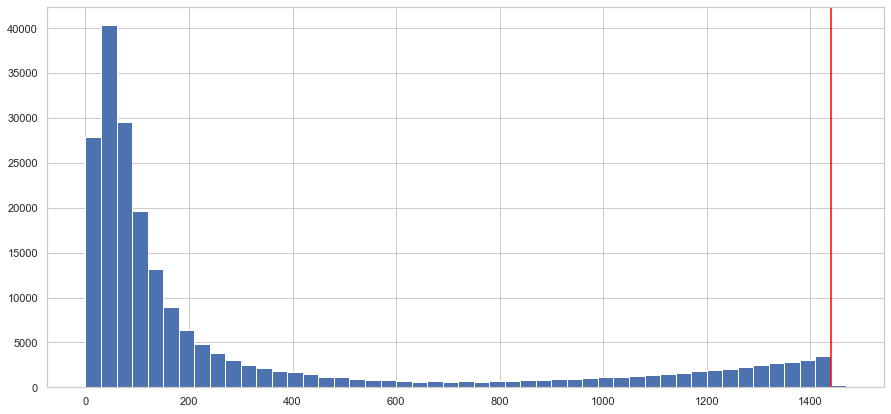

In [25]:
rents['time_used_minutes'] =round((rents['finisheddate'] - rents['startdate']).dt.seconds/60, 0).astype('int')
rents['time_used_minutes'].hist(bins=np.arange(0,1500,30)).axvline(1440,c="red");

The vast majority of rentals lasted less than 3 hours Almost all rentals did not exceed one day

**We leave only the necessary features without their duplication**

In [26]:
(rents['currenttariff_price'] == rents['price']).mean()

0.99999530337828

In [27]:
rents = rents[['id', 'currenttariff_period','finisheddate',
       'grouptariffs_periodcount', 'price',  'startdate',
       'totalamount', 'transaction','completionstation', 'startstation', 'stationid',
       'user_id', 'user_createddate', 'user_telegramloginstate',
       'user_webuser', 'tariff_group', 'free_period',
       'possible_payment_for_hours', 'time_used_minutes', 'only_days_payment',
       'united_tariff_groups', 'stationnumber']]

### Preparing rents for joining transactions

In [28]:
rents.transaction = rents.transaction.apply(ast.literal_eval)
rents = rents.explode('transaction')

## Тransactions

How does the financial interaction of the user with the service
The user creates his account, to which the bank card is attached
Transfers a certain amount from the card to this account - transaction CREDIT
When paying for the service, he transfers money from his account to the account of the company providing the service - DEBIT

Thus, from the transactions table, we are only interested in transactions with the DEBIT status

In [29]:
transactions = pd.read_csv('transactions.csv', low_memory = False)

In [30]:
transactions.columns = [x.replace('_', '').replace('.', '_').lower() for x in transactions.columns]

In [31]:
transactions.duplicated().sum()

0

In [32]:
transactions = transactions.query('transactionstatus == "DEBIT"')

In [33]:
data = rents.merge(transactions, left_on = 'transaction', right_on = 'id')

In [34]:
data.columns

Index(['id_x', 'currenttariff_period', 'finisheddate',
       'grouptariffs_periodcount', 'price_x', 'startdate', 'totalamount',
       'transaction', 'completionstation', 'startstation', 'stationid',
       'user_id_x', 'user_createddate_x', 'user_telegramloginstate_x',
       'user_webuser_x', 'tariff_group', 'free_period',
       'possible_payment_for_hours', 'time_used_minutes', 'only_days_payment',
       'united_tariff_groups', 'stationnumber', 'class', 'id_y', 'createddate',
       'description', 'price_y', 'rentid', 'transactionstatus', 'user_id_y',
       'user_blocking', 'user_createddate_y', 'user_roles',
       'user_telegramloginstate_y', 'user_webuser_y'],
      dtype='object')

In [35]:
check = data.groupby('id_x').agg({'totalamount':'first', 'price_y':'sum', 'transaction':'unique'})

In [36]:
(check['totalamount'] == check['price_y']).mean()

0.9360698932186937

In [37]:
rents = rents[['id', 'currenttariff_period','finisheddate',
       'grouptariffs_periodcount', 'price',  'startdate',
       'totalamount','completionstation', 'startstation', 'stationid',
       'user_id', 'user_createddate', 'user_telegramloginstate',
       'user_webuser', 'tariff_group', 'free_period',
       'possible_payment_for_hours', 'time_used_minutes', 'only_days_payment',
       'united_tariff_groups', 'stationnumber']].drop_duplicates()

**Conclusion**

In calculating income, we will be guided by the data from the total_amoun column of the rents table, which shows how much the user would pay (and this is 94 percent the same as the amount of real transactions) without taking into account the possibility of loss, powerbank breakdown, incorrect debiting of money from the account by the company, etc. Thus, since the transactions table was of interest to us solely because of comparing the amount of transactions with the calculated cost of using services, we work only with the rents table

# EDA

## Tariffs

In [38]:
rents['startdate'] = rents['startdate'].dt.date

In [39]:
rents['start_month'] = pd.to_datetime(rents['startdate'], format = "%Y-%m-%d").apply(lambda dt: dt.replace(day=1))
rents.startdate.agg(['max', 'min'])

max    2022-11-15
min    2020-05-27
Name: startdate, dtype: object

We will analyze the full period from 2020-06-01 to 2022-10-31

In [40]:
rents = rents.query('start_month > "2020-05-01" and start_month < "2022-11-01"')

### Number of rents per unique user

In [41]:
rent_per_unique = (rents.groupby(['united_tariff_groups'])
                   .agg({'id':'nunique', 'user_id':'nunique'})
                   .rename(columns = {'id':'rents_number', 'user_id':'unique_users_number'}))

rent_per_unique['rents_per_unique'] = rent_per_unique['rents_number']/rent_per_unique['unique_users_number']

all_rents_kpi = rent_per_unique.sort_values(by = 'rents_per_unique', ascending = False)
all_rents_kpi

,rents_number,unique_users_number,rents_per_unique
united_tariff_groups,,,
freetime_day,45217,7737,5.844255
only_day,97421,52150,1.868092
freetime_hour_day,42805,24563,1.742662
day_hour,22850,16864,1.354957


In [42]:
rent_per_unique = (rents.groupby(['tariff_group'])
                   .agg({'id':'nunique', 'user_id':'nunique'})
                   .rename(columns = {'id':'rents_number', 'user_id':'unique_users_number'}))

rent_per_unique['rents_per_unique'] = rent_per_unique['rents_number']/rent_per_unique['unique_users_number']

rent_per_unique.sort_values(by = 'rents_per_unique', ascending = False)

,rents_number,unique_users_number,rents_per_unique
tariff_group,,,
freeday_сутки100rub,31574,437,72.251716
30minutes1rub_сутки100rub,46,15,3.066667
cутки100rub,97421,52150,1.868092
free15minutes_cутки100rub,13503,7297,1.850487
free30minutes_сутки100rub,94,55,1.709091
freeminutes_час50rub_сутки100rub,18328,10759,1.703504
час50rub_сутки100rub,12892,7642,1.686993
free30minutes_час50rub_сутки100rub,20353,13739,1.481403
free60minutes_час50rub_сутки100rub,4124,3162,1.304238


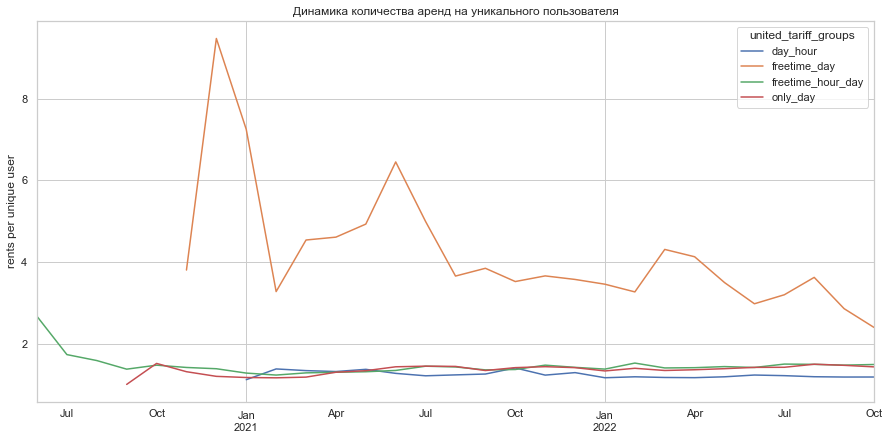

In [43]:
rent_per_unique_dynamics = (rents.reset_index().groupby(['united_tariff_groups', 'start_month'])
                            .agg({'id':'nunique', 'user_id':'nunique'})
                            .rename(columns = {'id':'rents_number', 'user_id':'unique_users_number'}).reset_index())

rent_per_unique_dynamics['rents_per_unique'] = (rent_per_unique_dynamics['rents_number']
                                                /rent_per_unique_dynamics['unique_users_number'])

(rent_per_unique_dynamics
 .pivot_table(index = 'united_tariff_groups', columns = 'start_month', values = 'rents_per_unique')
 .T.plot())
plt.title('Динамика количества аренд на уникального пользователя')
plt.ylabel('rents per unique user')
plt.xlabel('');

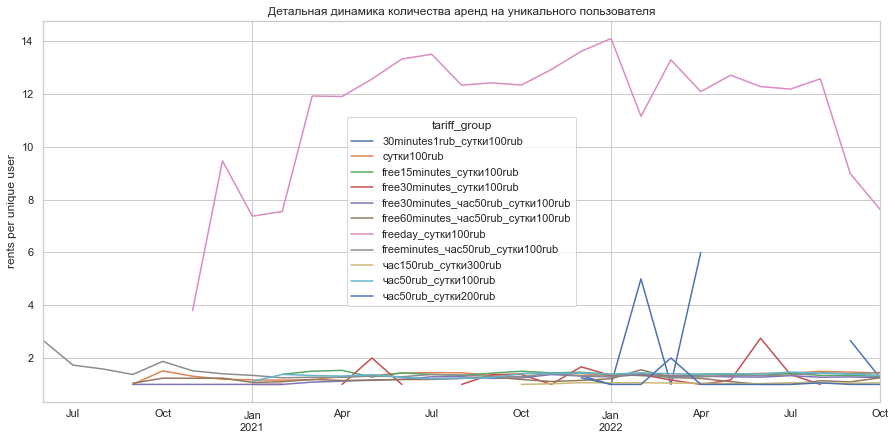

In [44]:
rent_per_unique_dynamics_details = (rents.reset_index().groupby(['tariff_group', 'start_month'])
                                    .agg({'id':'nunique', 'user_id':'nunique'})
                                    .rename(columns = {'id':'rents_number', 'user_id':'unique_users_number'}))

rent_per_unique_dynamics_details['rents_per_unique'] = (rent_per_unique_dynamics_details['rents_number']
                                                        /rent_per_unique_dynamics_details['unique_users_number'])

(rent_per_unique_dynamics_details
 .pivot_table(index = 'tariff_group', columns = 'start_month', values = 'rents_per_unique')
 .T.plot())
plt.title('Детальная динамика количества аренд на уникального пользователя')
plt.ylabel('rents per unique user')
plt.xlabel('');

**Conclusion**


We see that users are better returning to tariffs with free time and daily payment. At the same time, the best tariff for returning users is the tariff with free 24 hours at the beginning, and then daily payment, which is not surprising - this tariff has the largest amount of free time.

### Number of paid rents per unique user

In [45]:
rents = rents.reset_index()

In [46]:
paid_rent = rents.query('totalamount != 0').groupby(['united_tariff_groups'])['id'].nunique().reset_index()
unique_users = rents.groupby(['united_tariff_groups'])['user_id'].nunique().reset_index()
paid_rents_per_unique_user = paid_rent.merge(unique_users, on = 'united_tariff_groups')
paid_rents_per_unique_user['paid_rents_per_unique_user'] = (paid_rents_per_unique_user['id']
                                                            /paid_rents_per_unique_user['user_id'])
paid_rents_kpi = (paid_rents_per_unique_user.sort_values(by = 'paid_rents_per_unique_user', ascending = False)
 .rename(columns = {'id':'paid_rents_number', 'user_id':'unique_users_number'})).set_index('united_tariff_groups')
paid_rents_kpi

,paid_rents_number,unique_users_number,paid_rents_per_unique_user
united_tariff_groups,,,
only_day,97235,52150,1.864525
freetime_day,13985,7737,1.807548
freetime_hour_day,34941,24563,1.422505
day_hour,22787,16864,1.351222


In [47]:
paid_rent = rents.query('totalamount != 0').groupby(['tariff_group'])['id'].nunique().reset_index()
unique_users = rents.groupby(['tariff_group'])['user_id'].nunique().reset_index()
paid_rents_per_unique_user_details = paid_rent.merge(unique_users, on = 'tariff_group')
paid_rents_per_unique_user_details['paid_rents_per_unique_user'] = paid_rents_per_unique_user_details['id']/paid_rents_per_unique_user_details['user_id']
(paid_rents_per_unique_user_details
 .sort_values(by = 'paid_rents_per_unique_user', ascending = False)
 .rename(columns = {'id':'paid_rents_number', 'user_id':'unique_users_number'}))

,tariff_group,paid_rents_number,unique_users_number,paid_rents_per_unique_user
0,30minutes1rub_сутки100rub,45,15,3.000000
6,freeday_сутки100rub,975,437,2.231121
1,cутки100rub,97235,52150,1.864525
2,free15minutes_cутки100rub,12889,7297,1.766342
9,час50rub_сутки100rub,12851,7642,1.681628
7,freeminutes_час50rub_сутки100rub,17527,10759,1.629055
3,free30minutes_сутки100rub,76,55,1.381818
10,час50rub_сутки200rub,63,55,1.145455
4,free30minutes_час50rub_сутки100rub,14870,13739,1.082320
8,час150rub_сутки300rub,9873,9211,1.071871


In [48]:
paid_rents_kpi.merge(all_rents_kpi, right_index = True, left_index = True)[['paid_rents_per_unique_user', 'rents_per_unique']]

,paid_rents_per_unique_user,rents_per_unique
united_tariff_groups,,
only_day,1.864525,1.868092
freetime_day,1.807548,5.844255
freetime_hour_day,1.422505,1.742662
day_hour,1.351222,1.354957


**Conclusion**


  We see that the number of paid rentals per unique user for the freetime_day tariff less by 3 times compared to the same indicator for all rentals. That is, on average, out of 3 rentals for the unique of this tariff, only 1 is paid.
For freeday_day100rub, the number of paid rentals per unique is 35 times less than the number of all rentals - users are clearly abusing the free period of this tariff.

### Average rental price

In [49]:
average_rent_price_details = rents.groupby('tariff_group').agg({'id':'nunique', 'totalamount':'sum'})
average_rent_price_details['average_rent_price'] = (average_rent_price_details['totalamount']
                                                    /average_rent_price_details['id'])
(average_rent_price_details
 .sort_values(by = 'average_rent_price', ascending = False)
 .rename(columns = {'id':'rents_number', 'totalamount':'total_amount'}))

,rents_number,total_amount,average_rent_price
tariff_group,,,
час50rub_сутки200rub,63,19600.0,311.111111
час150rub_сутки300rub,9895,2117400.0,213.986862
cутки100rub,97421,19364500.0,198.771312
free15minutes_cутки100rub,13503,2676000.0,198.178183
час50rub_сутки100rub,12892,1870200.0,145.066708
free30minutes_сутки100rub,94,11500.0,122.340426
free30minutes_час50rub_сутки100rub,20353,2391023.0,117.477669
freeminutes_час50rub_сутки100rub,18328,1835725.0,100.159592
free60minutes_час50rub_сутки100rub,4124,344800.0,83.608147


In [50]:
rents.groupby('united_tariff_groups')\
     .agg({'id':'nunique',
           'user_id':'nunique',
           'totalamount':['sum','mean','median']})\
     .set_axis(['Rents','Users','Total sum','Mean sum','Median sum'],axis=1)\
     .sort_values('Total sum',ascending=False)

,Rents,Users,Total sum,Mean sum,Median sum
united_tariff_groups,,,,,
only_day,97421,52150,19364500.0,198.771312,100.0
freetime_hour_day,42805,24563,4571548.0,106.799393,50.0
day_hour,22850,16864,4007200.0,175.369803,100.0
freetime_day,45217,7737,2989345.0,66.111087,0.0


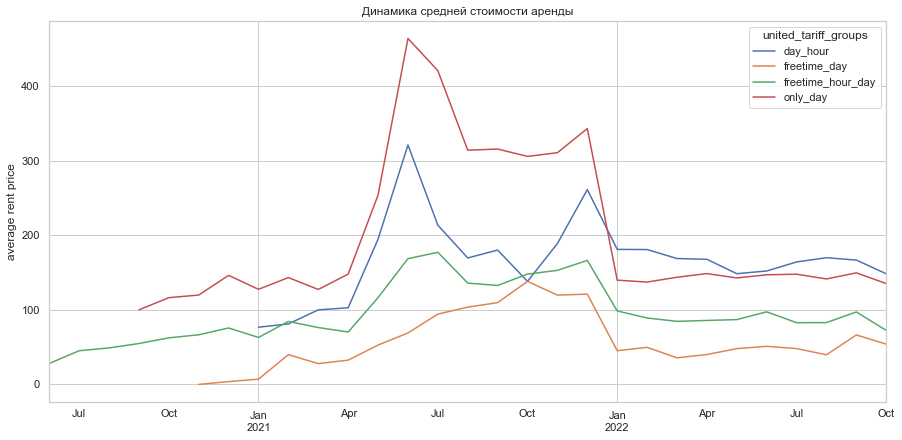

In [51]:
average_rent_price_dynamics = (rents.groupby(['united_tariff_groups', 'start_month'])
                               .agg({'id':'nunique', 'totalamount':'sum'})
                               
                               .rename(columns = {'id':'rents_number', 'totalamount':'rent_price'}))
average_rent_price_dynamics['average_rent_price'] = (average_rent_price_dynamics['rent_price']
                                                     /average_rent_price_dynamics['rents_number'])

(average_rent_price_dynamics
 .pivot_table(index = 'united_tariff_groups', columns = 'start_month', values = 'average_rent_price')
 .T.plot())
plt.title('Динамика средней стоимости аренды')
plt.ylabel('average rent price')
plt.xlabel('');

### Choosing the optimal return rate/revenue

In [52]:
perspective_tariffs = (average_rent_price_details
                       .merge(rent_per_unique.reset_index(), on = 'tariff_group')
                       [['average_rent_price', 'rents_per_unique', 'tariff_group']])

In [53]:
perspective_tariffs['profit_per_unique'] = perspective_tariffs['average_rent_price']*perspective_tariffs['rents_per_unique']
perspective_tariffs.sort_values(by = 'profit_per_unique', ascending = False)

,average_rent_price,rents_per_unique,tariff_group,profit_per_unique
6,9.558497,72.251716,freeday_сутки100rub,690.617849
1,198.771312,1.868092,cутки100rub,371.323106
2,198.178183,1.850487,free15minutes_cутки100rub,366.726052
10,311.111111,1.145455,час50rub_сутки200rub,356.363636
9,145.066708,1.686993,час50rub_сутки100rub,244.726511
8,213.986862,1.074259,час150rub_сутки300rub,229.877321
3,122.340426,1.709091,free30minutes_сутки100rub,209.090909
4,117.477669,1.481403,free30minutes_час50rub_сутки100rub,174.031807
7,100.159592,1.703504,freeminutes_час50rub_сутки100rub,170.622270
5,83.608147,1.304238,free60minutes_час50rub_сутки100rub,109.044908


**Conclusion**

Despite the low average rental cost for the freeday_day100rub tariff, the huge frequency of user returns provides the highest income for this tariff. On the other hand, we must understand that this tariff implies a large load on the service due to the large number of free rentals.

## Users

### Creating a table with user characteristics

In [54]:
def get_free_minutes(df):
    if df['price'] == 0:
        return df['time_used_minutes']
    else: return 0

In [55]:
rents['used_free_minutes'] = rents.apply(get_free_minutes, axis = 1)

In [56]:
rents['number_free_rents'] = rents['totalamount'].apply(lambda x : 1 if x == 0 else 0 )

In [57]:
users = (rents.groupby('user_id')
         .agg({'id':'nunique', 'totalamount':'sum', 'tariff_group':'nunique', 
               'time_used_minutes':'sum', 'used_free_minutes':'sum', 
               'free_period':'mean', 'possible_payment_for_hours':'mean', 
               'only_days_payment':'mean', 'number_free_rents':'sum'}))

In [58]:
users.describe(percentiles=[0.75, 0.90])

,id,totalamount,tariff_group,time_used_minutes,used_free_minutes,free_period,possible_payment_for_hours,only_days_payment,number_free_rents
count,96859.000000,96859.000000,96859.000000,96859.000000,96859.00000,96859.000000,96859.000000,96859.000000,96859.000000
mean,2.150476,319.356931,1.079115,680.077566,158.66190,0.313656,0.406390,0.593610,0.406209
std,10.548460,979.671729,0.307739,4944.250731,4180.31844,0.457253,0.485728,0.485728,9.238398
min,1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,100.000000,1.000000,89.000000,0.00000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,200.000000,1.000000,227.000000,0.00000,1.000000,1.000000,1.000000,0.000000
90%,3.000000,400.000000,1.000000,1327.000000,0.00000,1.000000,1.000000,1.000000,0.000000
max,1221.000000,29700.000000,7.000000,397544.000000,347197.00000,1.000000,1.000000,1.000000,1144.000000


In [59]:
users['percent_free_rents'] = users['number_free_rents']/users['id']

In [60]:
users.columns = ['rents_number', 'totalamount', 'number_tariffs', 'time_used_minutes',
       'used_free_minutes', 'free_period', 'possible_payment_for_hours',
       'only_days_payment', 'number_free_rents', 'percent_free_rents']

### Using the free part of the service

In [61]:
users['percent_free_rents'].value_counts(normalize=True).head()

0.000000    0.907412
1.000000    0.061471
0.500000    0.015590
0.333333    0.004605
0.250000    0.002158
Name: percent_free_rents, dtype: float64

**We clearly see a group of users around 6% who use exclusively free periods**

In [62]:
users.query('percent_free_rents == 1')['rents_number'].value_counts(normalize = True).head()

1    0.984044
2    0.004031
3    0.001344
5    0.000840
8    0.000840
Name: rents_number, dtype: float64

In [63]:
unpaid_users = users.query('percent_free_rents == 1').index

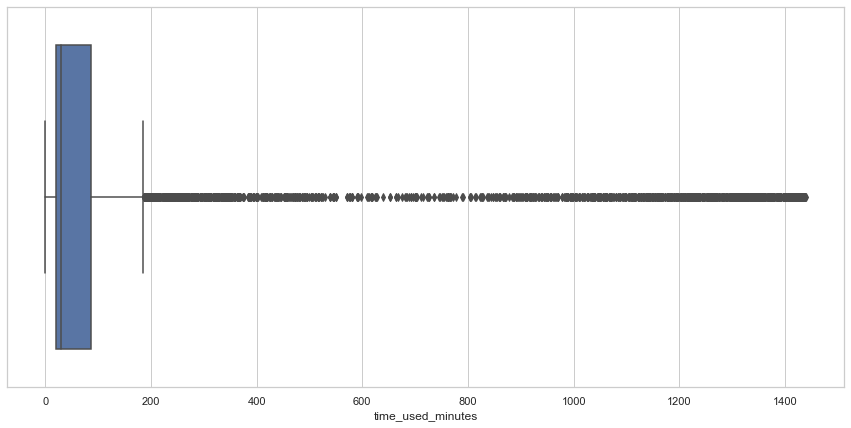

In [64]:
sns.boxplot(rents.query('user_id in @unpaid_users')['time_used_minutes']);

In [65]:
rents.query('user_id in @unpaid_users').describe()['time_used_minutes']

count    8550.000000
mean      183.615906
std       371.000537
min         0.000000
25%        21.000000
50%        29.000000
75%        86.750000
max      1440.000000
Name: time_used_minutes, dtype: float64

**Non-paying users do not create a load on the service - 98% make only one rent**

### Non-Returning Clients

Let's analyze the returning users - we will assume that the user who has rented more than 1 time is returned

In [66]:
churn_users = users.query('rents_number == 1').reset_index()['user_id']
churn = (rents.query('user_id in @churn_users')['tariff_group']
         .value_counts()
         .reset_index()
         .merge(rents['tariff_group'].value_counts().reset_index(), on = 'index'))
churn['churn'] = round(churn['tariff_group_x']/churn['tariff_group_y']*100, 0)
churn.sort_values(by = 'churn', ascending = False)

,index,tariff_group_x,tariff_group_y,churn
2,час150rub_сутки300rub,8293,9895,84.0
7,час50rub_сутки200rub,36,63,57.0
6,free60minutes_час50rub_сутки100rub,2212,4124,54.0
1,free30minutes_час50rub_сутки100rub,9860,20353,48.0
4,час50rub_сутки100rub,5261,12892,41.0
0,cутки100rub,37437,97421,38.0
5,free15minutes_cутки100rub,4735,13503,35.0
3,freeminutes_час50rub_сутки100rub,5984,18328,33.0
9,free30minutes_сутки100rub,14,94,15.0
10,30minutes1rub_сутки100rub,4,46,9.0


**Highest churn in the most expensive plan
The lowest - in a 24-hour free period followed by 100 rubles per day - all users of this tariff used it at least 2 times**

## Stations

### Correspondence of station id to its address

Check if a station with the same id could change its location

In [67]:
(rents.groupby('stationid')['startstation'].nunique() > 1).mean() 

0.7279821627647715

The data shows that about 73% of the stations changed their location. According to updated information from the customer, such a phenomenon really takes place.

We cannot use the station id as a unique identifier that determines whether it belongs to a particular establishment. We will be guided by station start, as a sign that determines where the station is located at the time of the lease

Let's take a look at how many establishments the stations were located in

In [68]:
addresses = rents.groupby('startstation')['stationid'].unique().reset_index()
len(addresses)

2023

In order to get information about the institution at its address, we will use the Yandex Maps API and write the received data to a csv file, since the API does not allow more than 1000 free requests per day

In [69]:
# import os
# from dotenv import load_dotenv

# dotenv_path = os.path.join('dot.env')
# if os.path.exists(dotenv_path):
#     load_dotenv(dotenv_path)
    
# KEY = os.environ['key']
# addresses['info'] = addresses['startstation'].apply(lambda x: requests.get(f'https://search-maps.yandex.ru/v1/?text={x}&type=biz&lang=ru_RU&results=1&apikey={KEY}').text)

In [70]:
addresses = pd.read_csv('all_addresses_chargex.csv').drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1)

In [71]:
def get_type(cell):
    try:
        return json.loads(cell.replace("'", '"'))['features'][0]['properties']['CompanyMetaData']['Categories'][0]['class']
    except:
        return np.nan

In [72]:
def get_address(cell):
    try:
        return json.loads(cell.replace("'", '"'))['features'][0]['properties']['description']
    except:
        return np.nan

In [73]:
addresses['type'] = addresses['info'].apply(get_type)
addresses['address'] = addresses['info'].apply(get_address)
addresses = addresses[['startstation', 'type', 'address']]

In [74]:
rents = rents.merge(addresses, how = 'left', on = 'startstation')

In [75]:
(rents.groupby('stationid')['address'].nunique() >1).mean()

0.6465997770345596

**After bringing the addresses of the starting stations to a single style, we found that about 65% of the stations change their location**

**Because we don't know the exact dates of installation of the station in the establishment and the end of its operation in this establishment, we cannot calculate indicators such as income per day or number of rentals per day to compare the attractiveness of installing stations in specific types of establishments. It is necessary to track the movements of stations by assigning unique identifiers to them depending on the location and indicating the start date of the station in the new location and the end date**

### Payback of the station 

In [76]:
stations_price = pd.DataFrame()
stations_price['numberslots'] = [4,8, 24, 48]
stations_price['price'] = [18000, 36000, 180000, 360000]

In [77]:
stations = pd.read_csv('stations.csv')
stations.columns = [x.lower().replace('.', '_') for x in stations.columns]
stations = stations.query('status == "CONNECTED"')
stations = stations.query('grouptariffs_location == "RU"')
stations['statusat'] = pd.to_datetime(stations['statusat'], format = '%Y-%m-%dT%H:%M:%S.%fZ').dt.date

In [78]:
stations['statusat'] = pd.to_datetime(stations['statusat'], format = '%Y-%m-%d')

In [79]:
rents = rents.sort_values(by = ['stationid', 'startdate'])
to_merge = rents.groupby('stationid').agg({'totalamount':'sum', 'price':'count', 'startdate':'first'}).reset_index()
to_merge.columns = ['stationid', 'totalamount', 'rents_number', 'first_rent_time']
to_merge['first_rent_time'] = pd.to_datetime(to_merge['first_rent_time'], format = '%Y-%m-%dT%H:%M:%S.%f')
res = stations.merge(to_merge, on = 'stationid', how = 'left')

In [80]:
res = res.merge(stations_price, on = 'numberslots')

In [81]:
res['revenue_owner'] = 0.75*res['totalamount']

In [82]:
((res['revenue_owner']-res['price']) > 0).mean()

0.28482003129890454

**About 28% of terminals paid off**

In [83]:
res['time_worked'] = (res['statusat'] - pd.to_datetime(res['first_rent_time'], format = '%Y-%m-%d')).dt.days

In [84]:
res['revenue_per_day'] = res['totalamount']/res['time_worked']*0.75

In [85]:
res['time_worked'] = (res['statusat'] - pd.to_datetime(res['first_rent_time'], format = '%Y-%m-%d')).dt.days

In [86]:
roi = res.groupby('numberslots')['revenue_per_day'].mean().reset_index().merge(stations_price, on = 'numberslots')

In [87]:
roi['months_for_return'] = roi['price']/roi['revenue_per_day']/30

**Payback periods**

In [88]:
roi

,numberslots,revenue_per_day,price,months_for_return
0,4,31.501496,18000,19.046714
1,8,75.781836,36000,15.834929
2,24,255.372007,180000,23.495136
